<a href="https://colab.research.google.com/github/arokem/IntroDL/blob/master/Copy_of_2019_Rokem_OHBM_IntroDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands on introduction to deep learning with Keras

## Educational Course: Deep Learning for Human Brain Mapping

### Organization for Human Brain Mapping, June 9th, 2019

[Ariel Rokem](https://arokem.org) and [Anisha Keshavan](https://anisha.pizza/braindr-results/#/)

In [1]:
!wget -nc https://raw.githubusercontent.com/arokem/conv-nets/master/conv_net_utils.py

File ‘conv_net_utils.py’ already there; not retrieving.



In [2]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

A single-layered neural net is simply a set of weights 

<img src='https://raw.githubusercontent.com/arokem/conv-nets/master/img/nn-1.png' width=500px>

Where: 

$X_{21} = X_{11} w^2_{11} + X_{12} w^2_{21}$

Let's implement this in code:

In [3]:
x11 = 1 
x12 = 2
w_2_11 = -2
w_2_21 = 3

In [4]:
x21 = w_2_11 * x11 + w_2_21 * x12

In [5]:
print(x21)

4


More generally: 

$X_{21} = w^2 \cdot X_{1}$


In [6]:
x21 = np.dot([w_2_11, w_2_21], [x11, x12])

In [7]:
print(x21)

4


A multi-layered network will add to that another set of weights: 

<img src='https://raw.githubusercontent.com/arokem/conv-nets/master/img/nn-2.png' width=500px>

In [8]:
x11 = 1 
x12 = 2

w_2_11 = -2
w_2_21 = 3
w_2_12 = 2
w_2_22 = -3

w_3_11 = 3
w_3_21 = 2

In [9]:
x21 = np.dot([w_2_11, w_2_21], [x11, x12])
x22 = np.dot([w_2_12, w_2_22], [x11, x12])

x31 = np.dot([w_3_11, w_3_21], [x21, x22])

In [10]:
print(x31)

4


Things get more interesting when an activation function is added to each unit:

<img src='https://raw.githubusercontent.com/arokem/conv-nets/master/img/nn-3.png' width=500px>

Different functions that are used include the hyperbolic tangent:

In [11]:
x = np.arange(-np.pi, np.pi, 0.001)

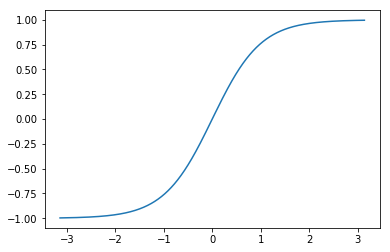

In [12]:
plt.plot(x, np.tanh(x))

Another function that has been used a lot, for both convenience, and because it induces sparsity, is a rectified linear unit:

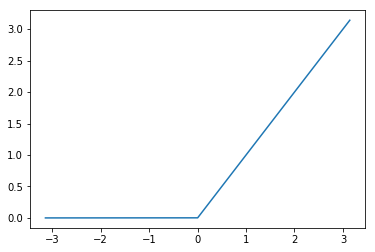

In [13]:
plt.plot(x, np.max([x, np.zeros(x.shape[0])], axis=0))

In [14]:
x21 = np.max([np.dot([w_2_11, w_2_21], [x11, x12]), 0])
x22 = np.max([np.dot([w_2_12, w_2_22], [x11, x12]), 0])

x31 = np.max([np.dot([w_3_11, w_3_21], [x21, x22]), 0])

In [15]:
print(x31)

12


Networks are trained through gradient descent: gradual changes to the values of the weights

The gradients are calculate through **backpropagation**

Error is propagated back through the network to calculate a gradient (derivative) for each weight by multiplying:

- The gradient of the loss function with respect to the node a weight feeds into
- The value of the node feeding into the weight
- The slope of the activation function of the node it feeds into

For example, for the network we had above, let's assume the desired output was 10, instead of 12

In [16]:
# We take the simplest possible error, the absolute difference:
e31 = x31 - 10

# We'll use this helper function to derive ReLU functions:
def d_relu(x):
    if x > 0:
        return 1
    else:
        return 0

e_3_11 = e31 * x21 * d_relu(x31)
e_3_21 = e31 * x22 * d_relu(x31)

e_2_11 = e_3_11 * x11 * d_relu(x21)
e_2_21 = e_3_11 * x12 * d_relu(x21)

e_2_12 = e_3_21 * x11 * d_relu(x22)
e_2_22 = e_3_21 * x12 * d_relu(x22)


In [17]:
lr = 0.01

In [18]:
w_3_11 = w_3_11 - e_3_11 * lr 
w_3_21 = w_3_11 - e_3_21 * lr 

w_2_11 = w_2_11 - e_2_11 * lr
w_2_12 = w_2_12 - e_2_12 * lr

w_2_21 = w_2_21 - e_2_21 * lr
w_2_22 = w_2_22 - e_2_22 * lr

In [19]:
x21 = np.max([np.dot([w_2_11, w_2_21], [x11, x12]), 0])
x22 = np.max([np.dot([w_2_12, w_2_22], [x11, x12]), 0])

x31 = np.max([np.dot([w_3_11, w_3_21], [x21, x22]), 0])

In [20]:
print(x31)

10.511999999999999


As we'll see next, depending on the error function that is used, neural nets can be used for other tasks as well

# Multilayer networks with Keras 


We will use a few functions from [`scikit-learn`](http://scikit-learn.org) to generate data sets:

In [21]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from conv_net_utils import generate_dataset

In [22]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### The first example is a linearly separable data-set:

In [23]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_blobs, 
                                                                    n_train=1000, 
                                                                    n_test=200, 
                                                                    num_labels=2,
                                                                    centers=2, 
                                                                    center_box=[-4., 4.])

In [24]:
train_data.shape, train_labels.shape

((1000, 2), (1000, 2))

In [25]:
train_data[:10]

array([[-0.80178666,  0.82728225],
       [-4.0641923 , -0.12157264],
       [-3.4008262 , -1.451171  ],
       [ 1.3761891 ,  1.3057818 ],
       [ 0.3383584 ,  0.6855264 ],
       [-6.3404636 , -0.37695238],
       [ 2.3187754 ,  0.95921206],
       [-1.7586356 , -1.8210063 ],
       [-2.698667  , -1.7209686 ],
       [-2.2190833 , -1.5116627 ]], dtype=float32)

In [26]:
train_labels[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

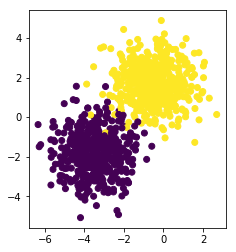

In [27]:
fig, ax = plt.subplots(1)
ax.scatter(train_data[:, 0], train_data[:, 1], c=np.where(train_labels)[1])
ax.set_aspect('equal')

In [28]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [29]:
model = Sequential()
model.add(Dense(32, input_shape=(train_data.shape[-1],), activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
model.fit(train_data, train_labels, epochs=5, batch_size=100, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s 196us/step - loss: 0.3506 - acc: 0.9238 - val_loss: 0.2990 - val_acc: 0.9500
Epoch 2/5
800/800 [==============================] - 0s 10us/step - loss: 0.2861 - acc: 0.9525 - val_loss: 0.2554 - val_acc: 0.9650
Epoch 3/5
800/800 [==============================] - 0s 14us/step - loss: 0.2466 - acc: 0.9612 - val_loss: 0.2231 - val_acc: 0.9650
Epoch 4/5
800/800 [==============================] - 0s 12us/step - loss: 0.2160 - acc: 0.9650 - val_loss: 0.1970 - val_acc: 0.9650
Epoch 5/5
800/800 [==============================] - 0s 12us/step - loss: 0.1908 - acc: 0.9725 - val_loss: 0.1750 - val_acc: 0.9700


In [31]:
loss_and_metrics = model.evaluate(test_data, test_labels, batch_size=100)

200/200 [==============================] - 0s 12us/step


In [32]:
for name, metric in zip(model.metrics_names, loss_and_metrics):
    print(name, ":", metric)

loss : 0.17678450793027878
acc : 0.9699999988079071


In [33]:
prediction = np.round(model.predict(test_data)).astype(int).squeeze()

In [34]:
prediction

array([[1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0,

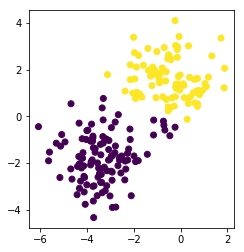

In [35]:
fig, ax = plt.subplots(1)
ax.scatter(test_data[:, 0], test_data[:, 1], c=np.where(prediction)[1])
ax.set_aspect('equal')



### The next set of data is not linearly separable:

In [36]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_circles, 
                                                                    n_train=1000,
                                                                    n_test=200, 
                                                                    noise=0.2, 
                                                                    num_labels=2,
                                                                    factor=0.1)

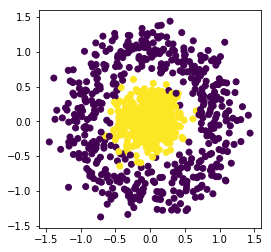

In [37]:
fig, ax = plt.subplots(1)
ax.scatter(train_data[:, 0], train_data[:, 1], c=np.where(train_labels)[1])
ax.set_aspect('equal')

In [38]:
model.fit(train_data, train_labels, nb_epoch=5, batch_size=100, validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s 11us/step - loss: 0.7112 - acc: 0.6163 - val_loss: 0.7118 - val_acc: 0.6000
Epoch 2/5
800/800 [==============================] - 0s 12us/step - loss: 0.6943 - acc: 0.6325 - val_loss: 0.6954 - val_acc: 0.6100
Epoch 3/5
800/800 [==============================] - 0s 10us/step - loss: 0.6785 - acc: 0.6412 - val_loss: 0.6797 - val_acc: 0.6300
Epoch 4/5
800/800 [==============================] - 0s 11us/step - loss: 0.6625 - acc: 0.6512 - val_loss: 0.6638 - val_acc: 0.6400
Epoch 5/5
800/800 [==============================] - 0s 11us/step - loss: 0.6473 - acc: 0.6700 - val_loss: 0.6487 - val_acc: 0.6450


/Users/arokem/.virtualenvs/conv-nets/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


In [39]:
loss_and_metrics = model.evaluate(test_data, test_labels, batch_size=100)
print()
for name, metric in zip(model.metrics_names, loss_and_metrics):
    print(name, ":", metric)

200/200 [==============================] - 0s 12us/step

loss : 0.6006800532341003
acc : 0.7099999785423279


In [40]:
prediction = np.round(model.predict(test_data)).astype(int).squeeze()

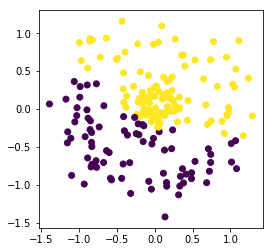

In [41]:
fig, ax = plt.subplots(1)
ax.scatter(test_data[:, 0], test_data[:, 1], c=np.where(prediction)[1])
ax.set_aspect('equal')

In [42]:
model = Sequential()
model.add(Dense(32, input_shape=(train_data.shape[-1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [43]:
model.fit(train_data, train_labels, epochs=5, batch_size=100, validation_split=0.2)
print()
loss_and_metrics = model.evaluate(test_data, test_labels, batch_size=100)
print()
for name, metric in zip(model.metrics_names, loss_and_metrics):
    print(name, ":", metric)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s 276us/step - loss: 0.6648 - acc: 0.6025 - val_loss: 0.6379 - val_acc: 0.7450
Epoch 2/5
800/800 [==============================] - 0s 14us/step - loss: 0.6231 - acc: 0.7788 - val_loss: 0.6008 - val_acc: 0.8350
Epoch 3/5
800/800 [==============================] - 0s 14us/step - loss: 0.5880 - acc: 0.8438 - val_loss: 0.5670 - val_acc: 0.8700
Epoch 4/5
800/800 [==============================] - 0s 14us/step - loss: 0.5550 - acc: 0.8762 - val_loss: 0.5337 - val_acc: 0.9000
Epoch 5/5
800/800 [==============================] - 0s 13us/step - loss: 0.5218 - acc: 0.9075 - val_loss: 0.5000 - val_acc: 0.9250

200/200 [==============================] - 0s 11us/step

loss : 0.48131321370601654
acc : 0.9149999916553497


In [44]:
prediction = np.round(model.predict(test_data)).astype(int).squeeze()

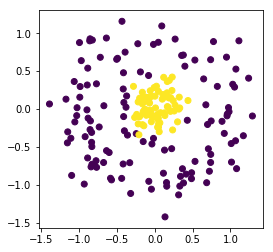

In [45]:
fig, ax = plt.subplots(1)
ax.scatter(test_data[:, 0], test_data[:, 1], c=np.where(prediction)[1])
ax.set_aspect('equal')

# Brain quality control with a deep learning network

In a paper we recently [published](https://www.frontiersin.org/articles/10.3389/fninf.2019.00029/full), we 
trained a neural network to accurately discriminate between high-quality and low-quality brain T1-weighted images from the [Healthy Brain Network](http://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/) dataset.

Here, we will do a slightly simpler task. Imagine that you have a dataset of brain saggital slices. In some images, the subjects are facing leftwards and in some images, the subjects are facing rightwards.

In [46]:
!wget -nc https://storage.googleapis.com/ohbm-dl-lindsay-data/Rokem_IXI_brain_data.npz

--2019-06-09 08:08:30--  https://storage.googleapis.com/ohbm-dl-lindsay-data/Rokem_IXI_brain_data.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.205.176
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.205.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 618670234 (590M) [application/octet-stream]
Saving to: ‘Rokem_IXI_brain_data.npz’

Rokem_IXI_brain_dat 100%[===================>] 590.01M  2.23MB/s    in 6m 59s  

2019-06-09 08:15:29 (1.41 MB/s) - ‘Rokem_IXI_brain_data.npz’ saved [618670234/618670234]



In [47]:
brain_data = np.load("Rokem_IXI_brain_data.npz")
train_data = brain_data['train_data']
test_data = brain_data['test_data']
train_labels = brain_data['train_labels']


test_labels = brain_data['test_labels']

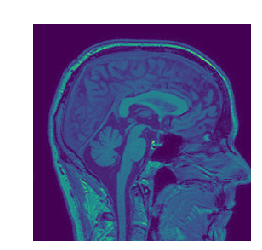

In [48]:
fig, ax = plt.subplots(1)
ax.matshow(train_data[0, :, :, 0])
ax.set_axis_off()

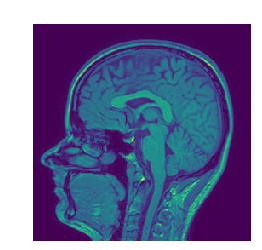

In [49]:
fig, ax = plt.subplots(1)
ax.matshow(train_data[1, :, :, 0])
ax.set_axis_off()

Let's train a neural network do discriminate between these two cases!

In [50]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((944, 256, 256, 1), (944,), (236, 256, 256, 1), (236,))

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [52]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [53]:
train_data_flat = train_data.reshape((train_data.shape[0], -1))
test_data_flat = test_data.reshape((test_data.shape[0], -1))

In [54]:
train_data.shape

(944, 256, 256, 1)

In [55]:
model = Sequential()
model.add(Dense(32, input_shape=(train_data_flat.shape[-1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [56]:
model.fit(train_data_flat, train_labels, epochs=10, batch_size=100, validation_split=0.2)
print()
loss_and_metrics = model.evaluate(test_data_flat, test_labels, batch_size=100)
print()
for name, metric in zip(model.metrics_names, loss_and_metrics):
    print(name, ":", metric)

Train on 755 samples, validate on 189 samples
Epoch 1/10
755/755 [==============================] - 1s 1ms/step - loss: 8.4317 - acc: 0.4742 - val_loss: 8.1017 - val_acc: 0.4974
Epoch 2/10
755/755 [==============================] - 0s 545us/step - loss: 8.0289 - acc: 0.5007 - val_loss: 8.1017 - val_acc: 0.4974
Epoch 3/10
755/755 [==============================] - 0s 510us/step - loss: 8.0289 - acc: 0.5007 - val_loss: 8.1017 - val_acc: 0.4974
Epoch 4/10
755/755 [==============================] - 0s 528us/step - loss: 8.0289 - acc: 0.5007 - val_loss: 8.1017 - val_acc: 0.4974
Epoch 5/10
755/755 [==============================] - 0s 543us/step - loss: 8.0289 - acc: 0.5007 - val_loss: 8.1017 - val_acc: 0.4974
Epoch 6/10
755/755 [==============================] - 0s 522us/step - loss: 8.0289 - acc: 0.5007 - val_loss: 8.1017 - val_acc: 0.4974
Epoch 7/10
755/755 [==============================] - 0s 513us/step - loss: 8.0289 - acc: 0.5007 - val_loss: 8.1017 - val_acc: 0.4974
Epoch 8/10
755/755

# What is a convolution? 

In [57]:
from conv_net_utils import plot_with_annot

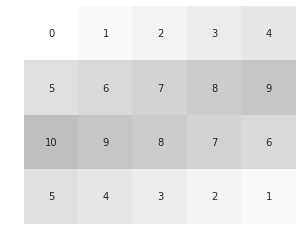

In [58]:
small_image = np.concatenate([np.arange(10), np.arange(10, 0, -1)]).reshape((4, 5))
fig1 = plot_with_annot(small_image)

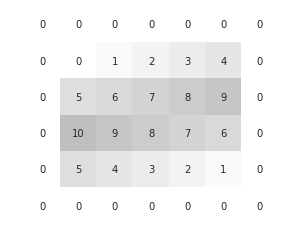

In [59]:
small_image = np.pad(small_image, 1, 'constant')
fig1 = plot_with_annot(small_image)

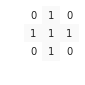

In [60]:
kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])

fig2 = plot_with_annot(kernel) 
fig2.set_size_inches([1, 1])

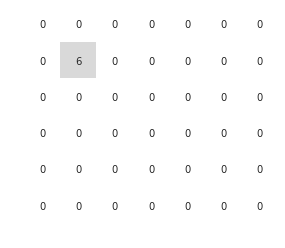

In [61]:
result = np.zeros(small_image.shape)

result[1, 1] += np.sum(small_image[:3, :3] * kernel)
fig3 = plot_with_annot(result)

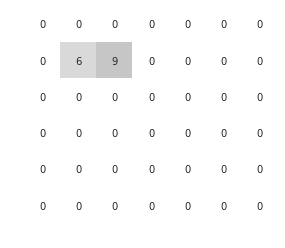

In [62]:
result[1, 2] += np.sum(small_image[:3, 1:4] * kernel)
fig3 = plot_with_annot(result)

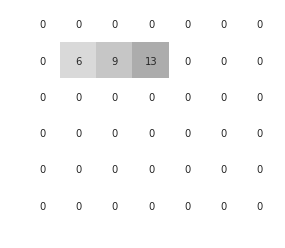

In [63]:
result[1, 3] += np.sum(small_image[:3, 2:5] * kernel)
fig3 = plot_with_annot(result)

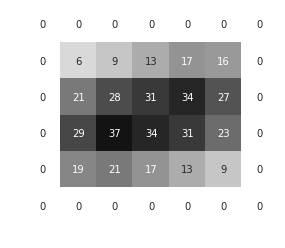

In [64]:
result = np.zeros(small_image.shape)

for ii in range(small_image.shape[0]-2):
    for jj in range(small_image.shape[1]-2):
        result[ii+1, jj+1] = np.sum(small_image[ii:ii+kernel.shape[0], jj:jj+kernel.shape[1]] * kernel)

_ = plot_with_annot(result)

In [65]:
im = train_data[0, :, :, 0]

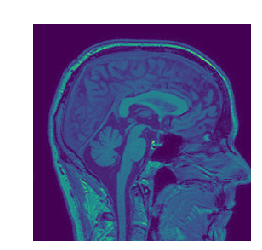

In [66]:
fig, ax = plt.subplots(1)
ax.matshow(im)
ax.set_axis_off()

In [67]:
conv = np.zeros(im.shape)

for ii in range(1, im.shape[0]-2):
    for jj in range(1, im.shape[1]-2):
        conv[ii, jj] = np.sum(im[ii:ii+kernel.shape[0], jj:jj+kernel.shape[1]] * kernel)


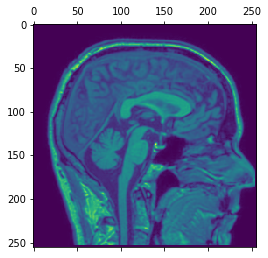

In [68]:
plt.matshow(conv)

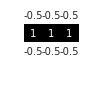

In [69]:
kernel = np.array([[-0.5, -0.5, -0.5], [1, 1, 1], [-0.5, -0.5, -0.5]])
fig2 = plot_with_annot(kernel, vmax=1)
fig2.set_size_inches([1, 1])

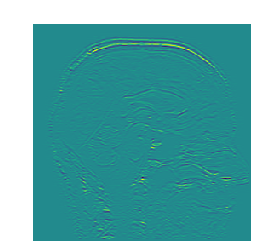

In [70]:
conv = np.zeros(im.shape)

for ii in range(1, im.shape[0]-2):
    for jj in range(1, im.shape[1]-2):
        conv[ii, jj] = np.sum(im[ii:ii+kernel.shape[0], jj:jj+kernel.shape[1]] * kernel)

fig, ax = plt.subplots(1)
ax.matshow(conv)
ax.set_axis_off()

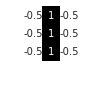

In [71]:
kernel = np.array([[-0.5, 1, -0.5], [-0.5, 1, -0.5], [-0.5, 1, -0.5]])
fig2 = plot_with_annot(kernel, vmax=1)
fig2.set_size_inches([1, 1])

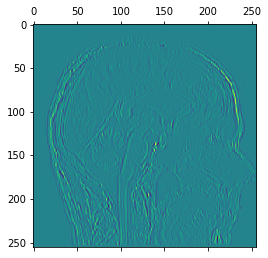

In [72]:
conv = np.zeros(im.shape)

for ii in range(1, im.shape[0]-2):
    for jj in range(1, im.shape[1]-2):
        conv[ii, jj] = np.sum(im[ii:ii+kernel.shape[0], jj:jj+kernel.shape[1]] * kernel)

plt.matshow(conv)

# Why are convolutions useful for neural networks?

- Natural images contain correlations
- Reduce the number of parameters in training

In [73]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, MaxPooling2D, Dropout

In [74]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, input_shape=train_data.shape[1:], activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [75]:
model.fit(train_data, train_labels, epochs=10, batch_size=100, validation_split=0.2)
print()
loss_and_metrics = model.evaluate(test_data, test_labels, batch_size=100)
print()
for name, metric in zip(model.metrics_names, loss_and_metrics):
    print(name, ":", metric)

Train on 755 samples, validate on 189 samples
Epoch 1/10
755/755 [==============================] - 18s 24ms/step - loss: 7.6552 - acc: 0.4821 - val_loss: 8.0164 - val_acc: 0.5026
Epoch 2/10
755/755 [==============================] - 15s 20ms/step - loss: 8.0504 - acc: 0.4993 - val_loss: 8.0164 - val_acc: 0.5026
Epoch 3/10
755/755 [==============================] - 15s 20ms/step - loss: 8.0503 - acc: 0.4993 - val_loss: 8.0164 - val_acc: 0.5026
Epoch 4/10
755/755 [==============================] - 15s 20ms/step - loss: 8.0503 - acc: 0.4980 - val_loss: 8.0164 - val_acc: 0.5026
Epoch 5/10
755/755 [==============================] - 14s 18ms/step - loss: 8.0502 - acc: 0.4993 - val_loss: 8.0164 - val_acc: 0.5026
Epoch 6/10
755/755 [==============================] - 13s 17ms/step - loss: 8.0502 - acc: 0.4993 - val_loss: 8.0164 - val_acc: 0.5026
Epoch 7/10
755/755 [==============================] - 13s 17ms/step - loss: 8.0502 - acc: 0.4993 - val_loss: 8.0164 - val_acc: 0.5026
Epoch 8/10
755/7

In [76]:
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD

In [77]:
kernel_size = (3, 3)
n_classes = 2

filters = 8

model = Sequential()

model.add(Conv2D(filters, kernel_size, activation='relu', 
                 input_shape=(256, 256, 1)))
# zero mean unit variance
model.add(BatchNormalization())

model.add(MaxPooling2D())
model.add(Conv2D(filters*2, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Conv2D(filters*4, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Conv2D(filters*8, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Conv2D(filters*16, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Conv2D(filters*32, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

learning_rate = 1e-5
# optimizer
adam = Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=adam, # swap out for sgd 
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 8)       80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 16)      1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        4640      
___________________________

In [78]:
model.fit(train_data, train_labels, epochs=10, batch_size=100, validation_split=0.2)
print()
loss_and_metrics = model.evaluate(test_data, test_labels, batch_size=100)
print()
for name, metric in zip(model.metrics_names, loss_and_metrics):
    print(name, ":", metric)

Train on 755 samples, validate on 189 samples
Epoch 1/10
755/755 [==============================] - 21s 28ms/step - loss: 0.8792 - acc: 0.5099 - val_loss: 0.7008 - val_acc: 0.5079
Epoch 2/10
755/755 [==============================] - 20s 26ms/step - loss: 0.7988 - acc: 0.5351 - val_loss: 0.6663 - val_acc: 0.6614
Epoch 3/10
755/755 [==============================] - 20s 26ms/step - loss: 0.8087 - acc: 0.4887 - val_loss: 0.6472 - val_acc: 0.7354
Epoch 4/10
755/755 [==============================] - 21s 27ms/step - loss: 0.7684 - acc: 0.5377 - val_loss: 0.6339 - val_acc: 0.7196
Epoch 5/10
755/755 [==============================] - 23s 30ms/step - loss: 0.7444 - acc: 0.5364 - val_loss: 0.6197 - val_acc: 0.7989
Epoch 6/10
755/755 [==============================] - 21s 28ms/step - loss: 0.7008 - acc: 0.5642 - val_loss: 0.6059 - val_acc: 0.8730
Epoch 7/10
755/755 [==============================] - 20s 27ms/step - loss: 0.6901 - acc: 0.5881 - val_loss: 0.5933 - val_acc: 0.9048
Epoch 8/10
755/7

## Bonus: visualize the activations in the network



In [79]:
from keras import backend as K

In [80]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

def show_activation(layer_name):
    
    layer_output = layer_dict[layer_name].output

    fn = K.function([model.input], [layer_output])
    
    inp = train_data[0:1]
    
    this_hidden = fn([inp])[0]
    
    # plot the activations from the first 8 filters
    plt.figure(figsize=(15,8))
    for i in range(8):
        plt.subplot(1,8,i+1)
        plt.imshow(this_hidden[0,:,:,i], plt.cm.Greys_r)
        plt.axis('off')
    
    return

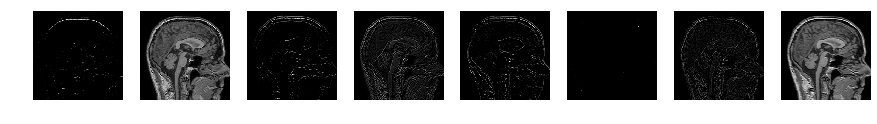

In [81]:
show_activation('conv2d_2')

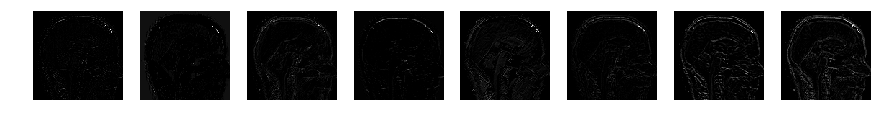

In [82]:
show_activation('conv2d_3')

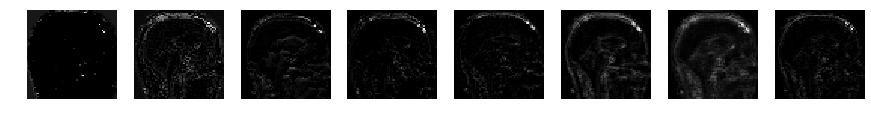

In [83]:
show_activation('conv2d_4')

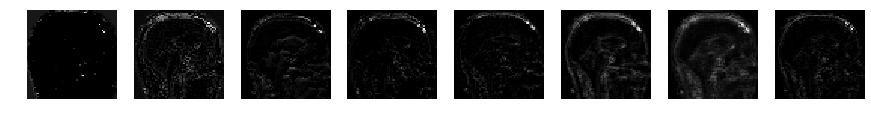

In [84]:
show_activation('conv2d_4')

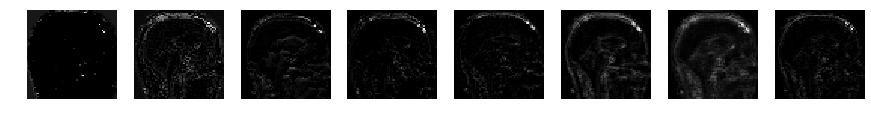

In [85]:
show_activation('conv2d_4')

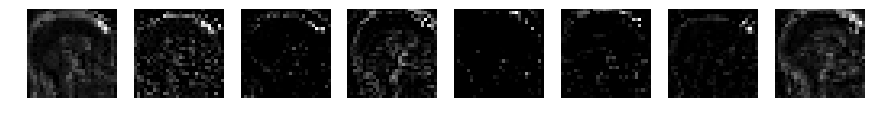

In [86]:
show_activation('conv2d_5')

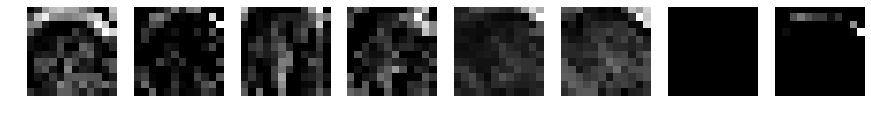

In [87]:
show_activation('conv2d_6')

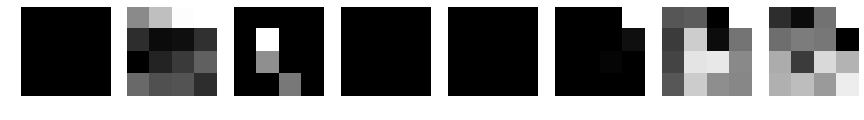

In [88]:
show_activation('conv2d_7')